# Import and Cleaning

In [1]:
# adding path to import custom functions
import sys
sys.path.append("/home/artur/code/masters-project/main_project/notebooks/model_creation")

In [2]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter, gmtime, strftime

from functions import remove_high_corr, scale_variables, best_params_grid, calculate_confusion_matrix, plot_roc_auc_curve, bart_auc_scorer, make_label, get_error_and_auc

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedKFold, train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer

from ISLP.bart import BART

import session_info 

In [3]:
data = pd.read_csv("../data/pre_processed_zinc_rdkit.csv")
data.head()

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,AvgIpc,fda_approved
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,-2.775558e-17,0.0,1.875121,1.0
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,-2.775558e-17,0.0,2.093155,1.0
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,-2.775558e-17,1.0,2.265927,1.0
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,-2.775558e-17,0.0,2.167598,1.0
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,-2.775558e-17,0.0,1.889887,1.0


In [4]:
Y = data["fda_approved"]
Y = Y.astype(float)
Y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: fda_approved, dtype: float64

In [5]:
X = data.iloc[:, 14:-1]
X.head()

,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,AvgIpc
0,6.055556,-0.333333,0.333333,0.242956,59.072,0.0,0.182528,-0.370334,1.50,14.880242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.775558e-17,0.0,1.875121
1,9.451389,-0.439815,0.439815,0.301333,75.067,0.0,0.239711,-0.288644,2.00,16.466627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.775558e-17,0.0,2.093155
2,9.229167,-0.939815,0.939815,0.256644,76.055,0.0,0.335391,-0.349891,2.00,16.470004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.775558e-17,1.0,2.265927
3,4.951389,0.683642,0.683642,0.419021,77.152,0.0,0.002549,-0.329661,1.75,32.116866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.775558e-17,0.0,2.167598
4,9.555556,-0.611111,0.611111,0.373753,78.136,0.0,0.094572,-0.616764,1.50,32.227566,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.775558e-17,0.0,1.889887


In [6]:
# separate train an test datasets

np.random.seed(6752)
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

# Constant Variables

In [7]:
DESCRIPTOR_TYPE = "rdkit"

# Scaling datsets

The datasets are being scaled to be used, when necessary, scaled

In [8]:
# TRAIN
x_train_scaled = scale_variables(x_train)

# adding constant
x_train_scaled = sm.add_constant(x_train_scaled)

x_train_scaled.head()

,const,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,AvgIpc
0,1.0,0.479639,0.478816,-0.474728,0.374806,0.052430,-0.018761,-0.077105,0.846862,-0.554829,...,-0.302885,-0.258332,-0.139172,-0.097936,-0.110038,-0.227308,-0.218283,-0.169024,-0.268775,0.765570
1,1.0,-2.240975,1.023349,1.212319,0.224996,-0.956142,-0.018761,-0.792962,0.320043,-0.100791,...,-0.302885,-0.258332,-0.139172,-0.097936,-0.110038,-0.227308,-0.218283,-0.169024,-0.268775,-0.758294
2,1.0,-2.161582,1.057971,1.428785,0.373334,-0.577868,-0.018761,-1.207771,1.900691,-0.499459,...,-0.302885,-0.258332,-0.139172,-0.097936,-0.110038,-0.227308,-0.218283,-0.169024,-0.268775,0.578724
3,1.0,2.185913,-0.912951,-0.710928,-0.070711,0.944818,-0.018761,0.387771,-0.489450,-0.056495,...,-0.302885,-0.258332,-0.139172,-0.097936,-0.110038,-0.227308,-0.218283,-0.169024,-0.268775,0.293102
4,1.0,-2.431348,1.114745,1.783753,0.755404,-1.078057,-0.018761,-1.647065,-0.978069,0.441840,...,-0.302885,-0.258332,-0.139172,-0.097936,-0.110038,-0.227308,-0.218283,-0.169024,-0.268775,-2.625145


In [9]:
# TEST
x_test_scaled = scale_variables(x_test)

# adding constant
x_test_scaled = sm.add_constant(x_test_scaled)

x_test_scaled.head()

,const,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,AvgIpc
0,1.0,-0.913538,0.342675,0.120502,0.040372,-1.471434,0.0,-1.680579,-1.207684,1.631871,...,-0.313343,-0.26188,-0.157686,-0.065094,-0.113228,-0.212853,-0.243518,-0.175878,-0.260082,-1.413975
1,1.0,-0.333334,0.016978,0.431417,-1.047675,2.800626,0.0,0.604777,-1.177564,-0.567389,...,-0.313343,-0.26188,-0.157686,-0.065094,-0.113228,-0.212853,-0.243518,-0.175878,-0.260082,-0.759839
2,1.0,1.110899,0.353526,0.154589,1.324632,-0.279202,0.0,1.653389,-0.317260,1.032073,...,-0.313343,-0.26188,-0.157686,-0.065094,-0.113228,-0.212853,-0.243518,-0.175878,-0.260082,-0.237617
3,1.0,0.078354,0.297007,0.338852,-0.289579,0.348009,0.0,0.590058,-1.044032,0.032409,...,-0.313343,-0.26188,-0.157686,-0.065094,-0.113228,-0.212853,-0.243518,-0.175878,3.716657,0.013660
4,1.0,0.301901,0.700168,-0.628191,0.767295,-0.384163,0.0,0.086541,1.108379,0.032409,...,-0.313343,-0.26188,-0.157686,-0.065094,-0.113228,-0.212853,-0.243518,-0.175878,-0.260082,1.417033


# Logistic Regression

## Model Constant Variables

In [10]:
model_name_title = "Logistic Regression"
model_name_path = "logistic_regression"

## Cross Validation

Here, I will use the best_params_grid function, which looks for the best hyperparameters, using CV. There are no hyperparameters in Logistic Regression, so this function will only perform CV.

In [11]:
model_params_lr = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {}
    }
}

In [12]:
gs_result_lr, gs_result_lr_full = best_params_grid(x_train_scaled, y_train, model_params_lr)

Starting Grid Search for Logistic Regression: 16:56


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Finished Grid Search for Logistic Regression: 16:56
Tempo de execução:  0.0 minutos


In [13]:
gs_result_lr

,model,best_score,best_params
0,Logistic Regression,0.906918,{}


## Fitting Model to Train Dataset

To fit the model, I will use the Logit function, from the statsmodel library, because it gives more information about feature importance.

In [14]:
# adjusting y_train index and type

y_train.index = range(0, x_train_scaled.shape[0])

In [15]:
# calculatin model

log_reg = LogisticRegression().fit(x_train_scaled, y_train)

# log_reg = sm.Logit(y_train, x_train_scaled).fit()
# log_reg_results = log_reg.summary()

## Get Training Error and AUC

In [16]:
mis_rate_lr_train, auc_lr_train = get_error_and_auc(
    model=log_reg, 
    x=x_train_scaled,
    y_true=y_train,
    transform_prob_into_label=True
)

Training Misclassification Rate: 0.1386
Training AUC: 0.8614


## Make Predictions

In [17]:
y_predict_labels_lr = log_reg.predict(x_test_scaled)
y_predict_lr_prob = log_reg.predict_proba(x_test_scaled)[:, 1]

## Test Error

In [18]:
mis_rate_lr, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_labels_lr,
)

Misclassification rate: 0.1688


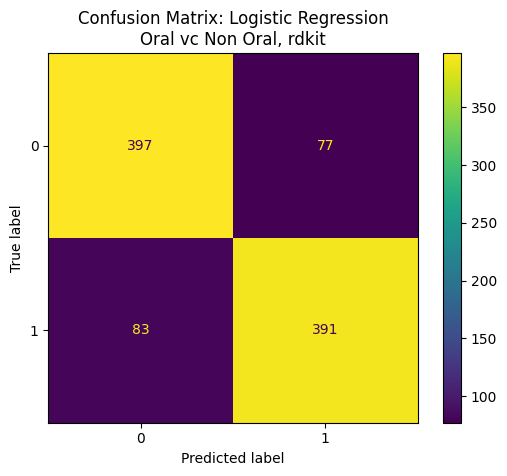

In [19]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

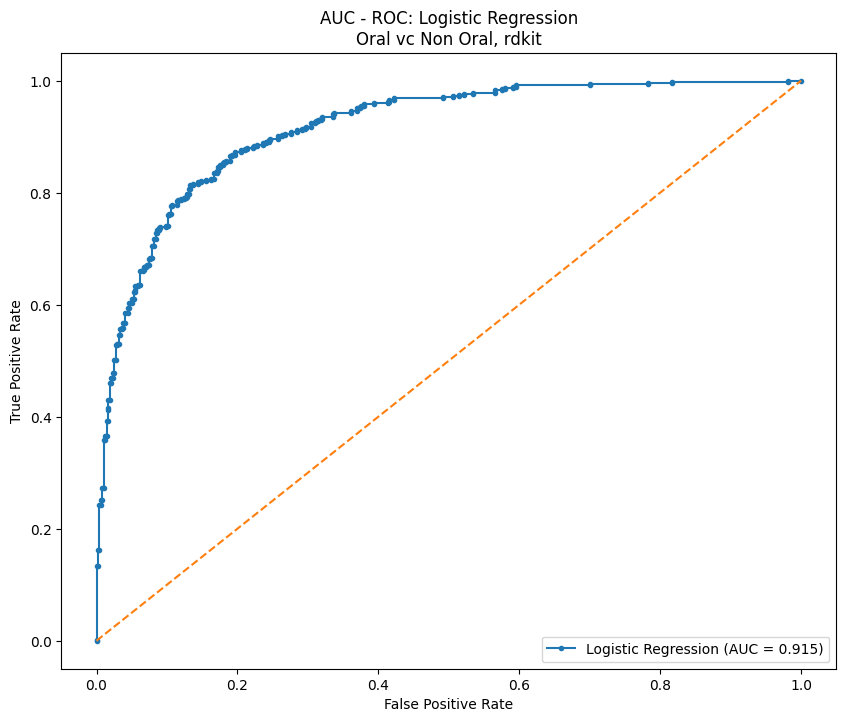

In [20]:
auc_lr = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_lr_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Saving Results

In [21]:
# creating dataset to store final results from each model
final_results = pd.DataFrame(
    columns=[
        "model_name", 
        "cv_test_auc", 
        "training_mis_rate", 
        "test_mis_rate", 
        "training_auc",
        "test_auc"
    ]
)

In [22]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_lr["best_score"][0],
    mis_rate_lr_train,
    mis_rate_lr,
    auc_lr_train,
    auc_lr
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.906918,0.138635,0.168776,0.861365,0.915118


# TREES

# Decision Tree

## Model Constant Variables

In [23]:
model_name_title = "Decision Tree"
model_name_path = "decision_tree"

## Hyperparameter Fine Tuning

In [24]:
model_params = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [1, 5, 10, 20, 50, 100, 150],
            'ccp_alpha': [0, 0.0001, 0.001, 0.1, 0.5, 1]
        }
    }
}

In [25]:
gs_result_dt, gs_result_dt_full = best_params_grid(x_train_scaled, y_train, model_params)

Starting Grid Search for Decision Tree: 16:56
Finished Grid Search for Decision Tree: 17:02
Tempo de execução:  6.1 minutos


In [26]:
gs_result_dt

,model,best_score,best_params
0,Decision Tree,0.847638,"{'ccp_alpha': 0, 'criterion': 'log_loss', 'max..."


## Fitting Tree

In [27]:
decision_tree_params = gs_result_dt.iloc[0,2]
decision_tree_params

{'ccp_alpha': 0, 'criterion': 'log_loss', 'max_depth': 5}

In [28]:
decision_tree = DecisionTreeClassifier(**decision_tree_params).fit(x_train_scaled, y_train)

## Get Training Error and AUC

In [29]:
mis_rate_dt_train, auc_dt_train = get_error_and_auc(
    model=decision_tree, 
    x=x_train_scaled,
    y_true=y_train,
)

Training Misclassification Rate: 0.1671
Training AUC: 0.8329


## Make Predictions

In [30]:
y_predict_dt_label = decision_tree.predict(x_test_scaled)
y_predict_dt_prob = decision_tree.predict_proba(x_test_scaled)[:, 1]

## Test Error

In [31]:
mis_rate_dt, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_dt_label,
)

Misclassification rate: 0.2173


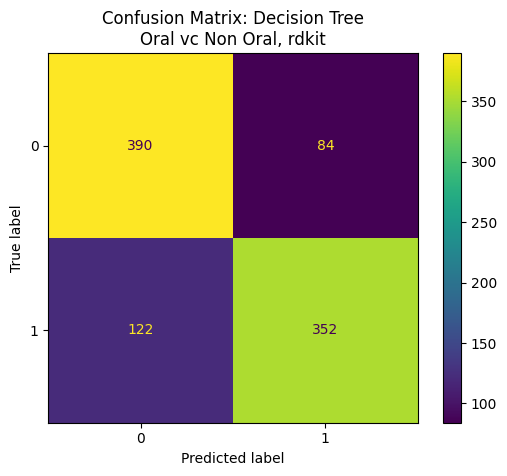

In [32]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

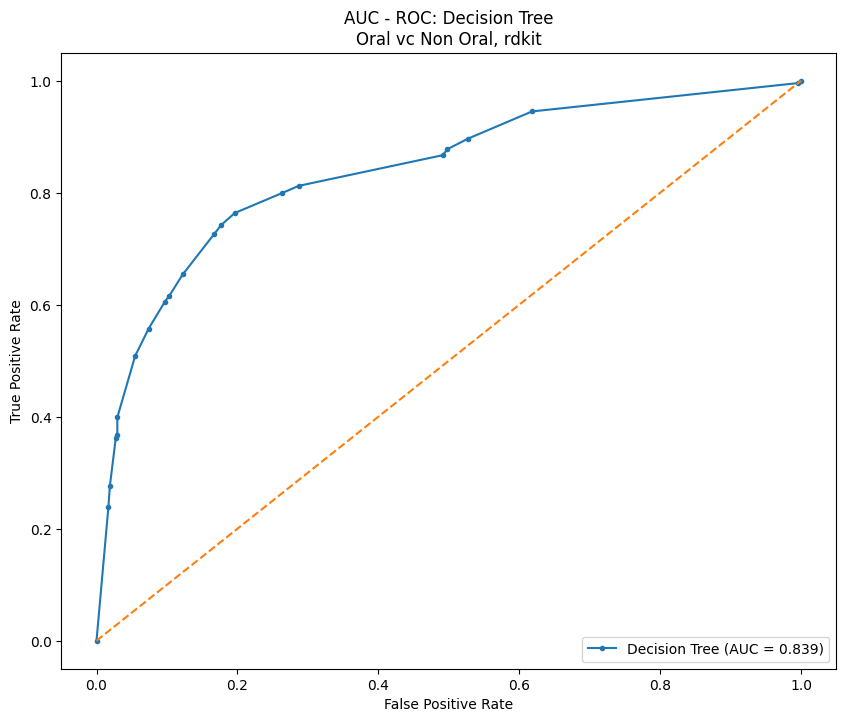

In [33]:
auc_dt = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_dt_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Visualizing the Tree

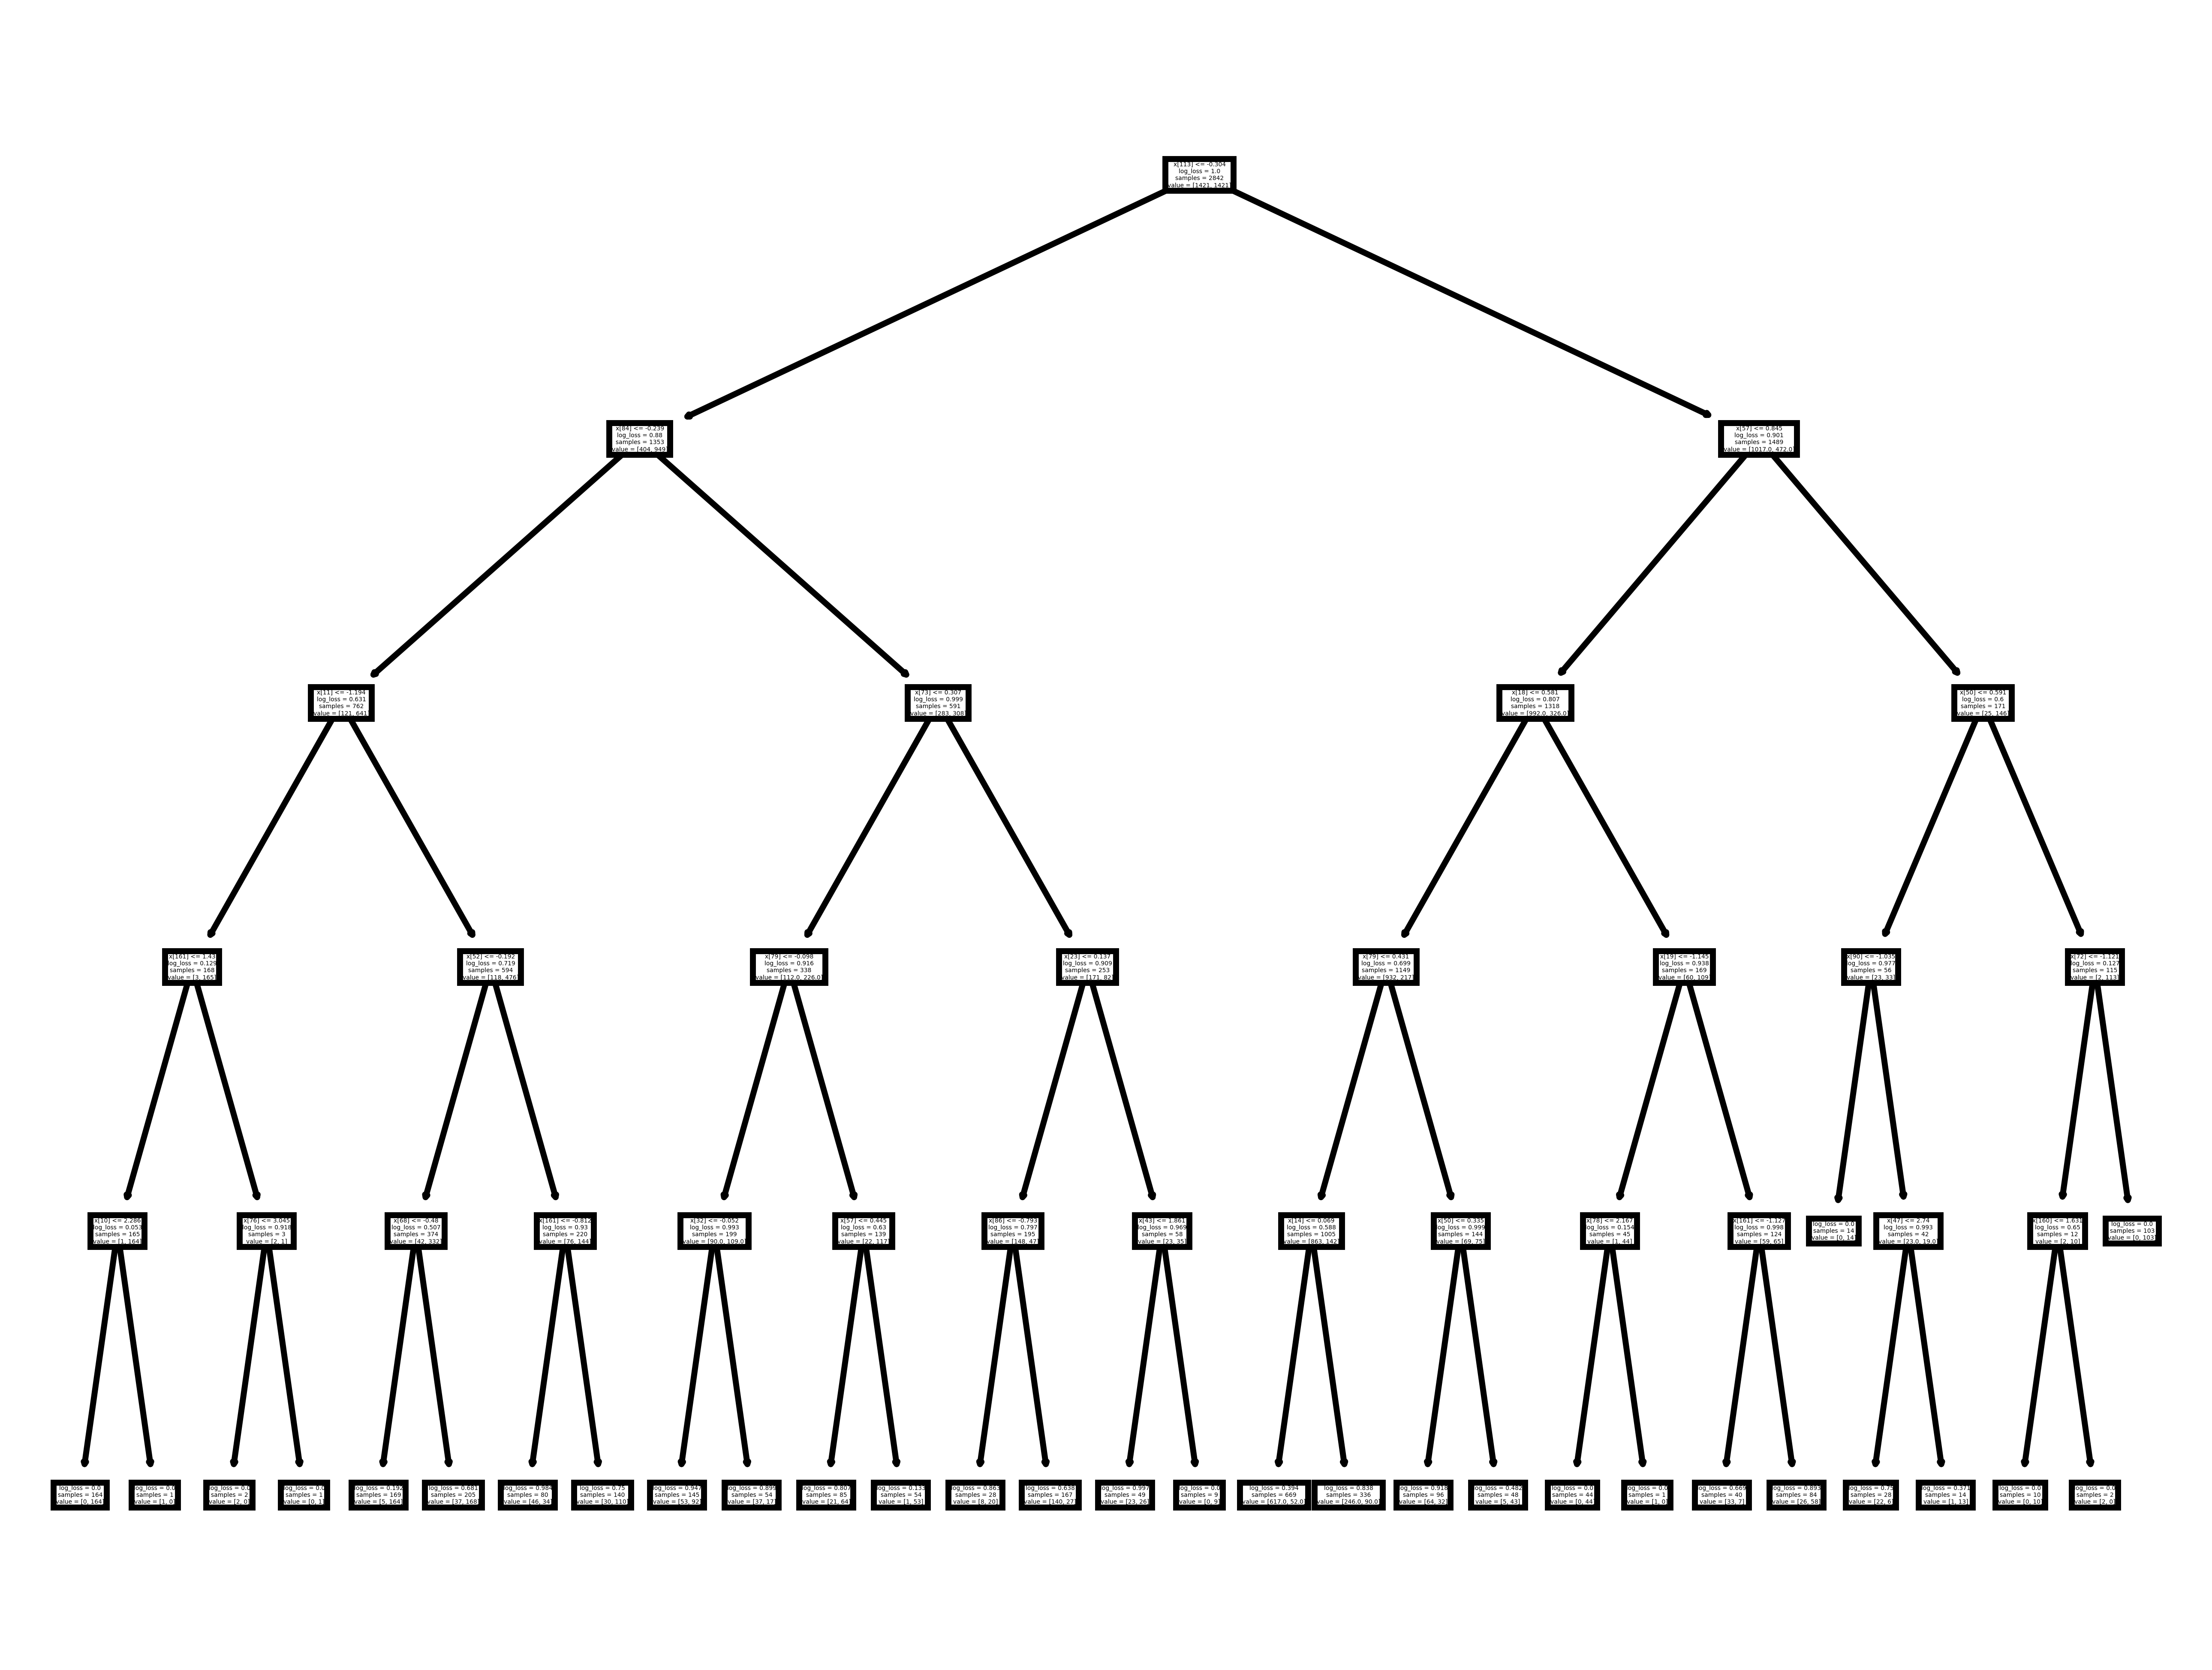

In [34]:
fig, ax = plt.subplots()
fig.dpi = 1000

tree.plot_tree(decision_tree, ax=ax)
plt.show()

fig.savefig(f"imgs/decision_tree_{DESCRIPTOR_TYPE}", dpi=1000)

## Feature Importance

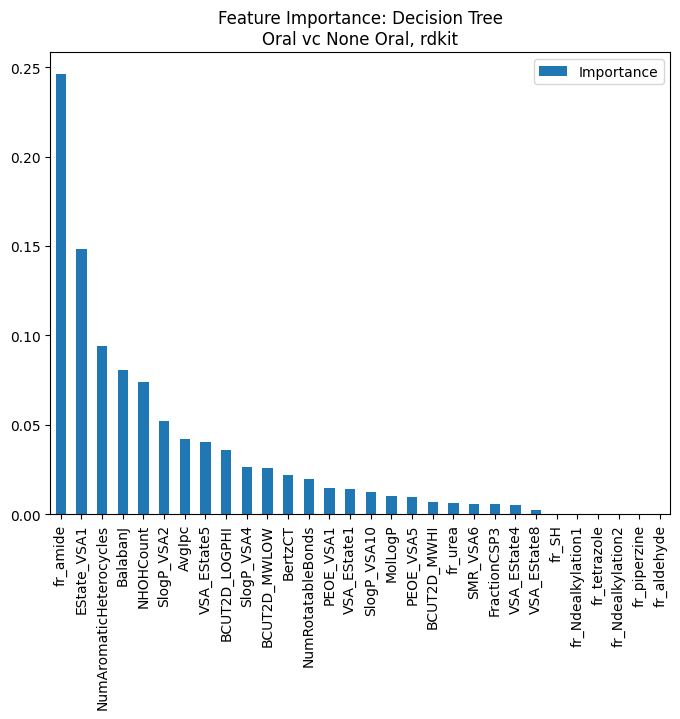

In [35]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(decision_tree.feature_importances_, index=x_train_scaled.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [36]:
important_features_dt = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_dt

,Importance
VSA_EState8,0.002186
VSA_EState4,0.005356
FractionCSP3,0.005489
SMR_VSA6,0.005815
fr_urea,0.006189
BCUT2D_MWHI,0.006986
PEOE_VSA5,0.009380
MolLogP,0.010298
SlogP_VSA10,0.012329
VSA_EState1,0.013816


## Saving Results

In [37]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_dt["best_score"][0],
    mis_rate_dt_train,
    mis_rate_dt,
    auc_dt_train,
    auc_dt
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.906918,0.138635,0.168776,0.861365,0.915118
1,Decision Tree,0.847638,0.167136,0.217300,0.832864,0.838899


In [38]:
important_features_dt.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Random Forest and Bagging

Bagging is just Random Forest, in which max_features is equal to the total number of features. Therefore, bagging will be done in the RF algorithm, and compared to RF.

## Model Constant Variables

In [39]:
model_name_title = "Random Forest"
model_name_path = "random_forest"

## Hyperparameter Fine Tuning

In [40]:
model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 500, 1000], # number of trees
            'max_depth': [10, 50, 100],
            'max_features': ["sqrt", "log2", x_train.shape[1]], # m, number of features considered in split. When it is equal to all predictor of dataset, it is bagging
            'ccp_alpha': [0, 0.1, 0.5, 1]
        }
    }
}

In [41]:
gs_result_rf, gs_result_rf_full = best_params_grid(x_train_scaled, y_train, model_params)

Starting Grid Search for Random Forest: 17:02
Finished Grid Search for Random Forest: 07:17
Tempo de execução:  854.5 minutos


In [42]:
gs_result_rf

,model,best_score,best_params
0,Random Forest,0.944589,"{'ccp_alpha': 0, 'max_depth': 50, 'max_feature..."


## Fitting Model

In [43]:
random_forest_params = gs_result_rf.iloc[0,2]
random_forest_params

{'ccp_alpha': 0, 'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 1000}

In [44]:
random_forest = RandomForestClassifier(**random_forest_params).fit(x_train_scaled, y_train)

## Make Predictions

In [45]:
y_predict_rf_label = random_forest.predict(x_test_scaled)
y_predict_rf_prob = random_forest.predict_proba(x_test_scaled)[:, 1]

## Get Training Error and AUC

In [46]:
mis_rate_rf_train, auc_rf_train = get_error_and_auc(
    model=random_forest, 
    x=x_train_scaled,
    y_true=y_train,
)

Training Misclassification Rate: 0.0000
Training AUC: 1.0000


## Test Error

In [47]:
mis_rate_rf, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_rf_label,
)

Misclassification rate: 0.1297


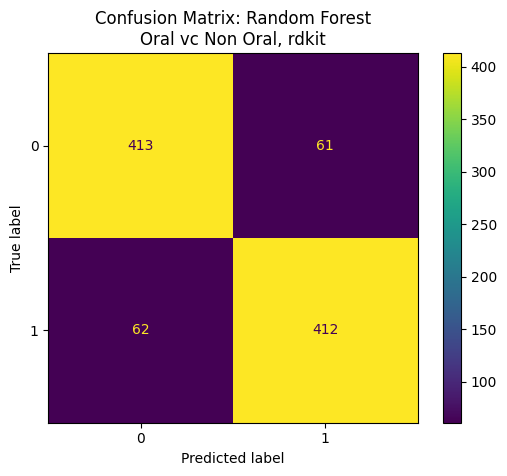

In [48]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

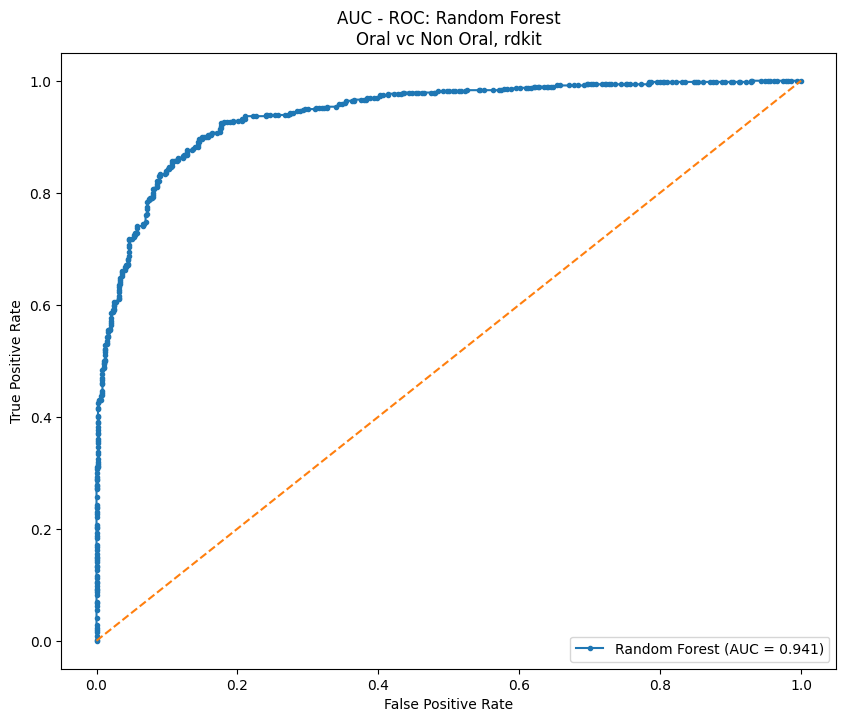

In [49]:
auc_rf = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_rf_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

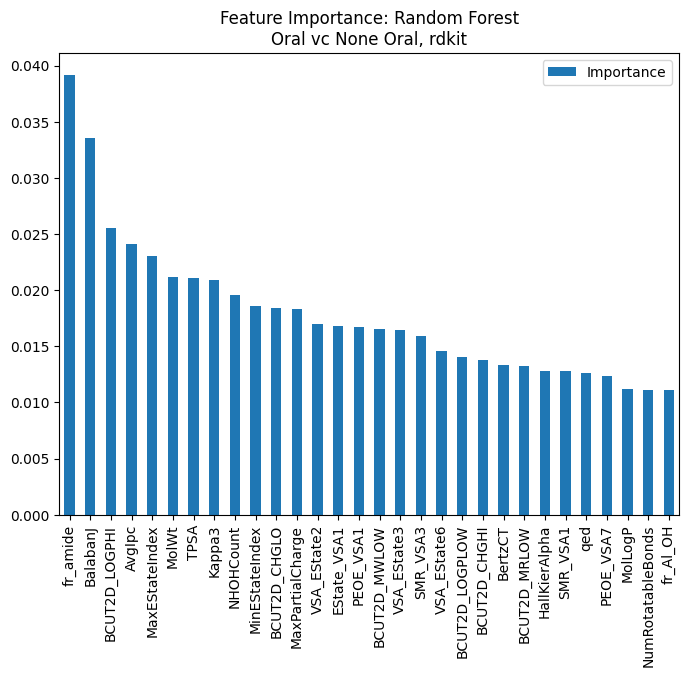

In [50]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(random_forest.feature_importances_, index=x_train_scaled.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [51]:
important_features_rf = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_rf

,Importance
Ipc,9.579346e-07
fr_azide,1.138475e-06
NumRadicalElectrons,2.068164e-06
fr_nitroso,1.282178e-05
fr_phos_acid,3.180905e-05
...,...
MaxEStateIndex,2.303271e-02
AvgIpc,2.406901e-02
BCUT2D_LOGPHI,2.557172e-02
BalabanJ,3.353168e-02


## Saving Results

In [52]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_rf["best_score"][0],
    mis_rate_rf_train,
    mis_rate_rf,
    auc_rf_train,
    auc_rf
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.906918,0.138635,0.168776,0.861365,0.915118
1,Decision Tree,0.847638,0.167136,0.217300,0.832864,0.838899
2,Random Forest,0.944589,0.000000,0.129747,1.000000,0.941068


In [53]:
important_features_rf.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Boosting

## Model Constant Variables

In [54]:
model_name_title = "Gradiant Boosting"
model_name_path = "boosting"

## Hyperparameter Fine Tuning

In [55]:
model_params = {
    'Boosting': {
            'model': GradientBoostingClassifier(),
            'params': {
                'n_estimators' : [100, 500, 1000], # number of trees
                'learning_rate': [0.001, 0.1, 1], # alfa
                'max_depth': [10, 20, 50],
        }
    }
}

In [56]:
gs_result_boo, gs_result_boo_full = best_params_grid(x_train_scaled, y_train, model_params)

Starting Grid Search for Boosting: 07:17
Finished Grid Search for Boosting: 13:53
Tempo de execução:  396.3 minutos


In [57]:
gs_result_boo

,model,best_score,best_params
0,Boosting,0.951969,"{'learning_rate': 1, 'max_depth': 10, 'n_estim..."


## Fitting Model

In [58]:
boosting_params = gs_result_boo.iloc[0,2]
boosting_params

{'learning_rate': 1, 'max_depth': 10, 'n_estimators': 500}

In [59]:
boosting = GradientBoostingClassifier(**boosting_params).fit(x_train_scaled, y_train)

## Get Training Error and AUC

In [60]:
mis_rate_boo_train, auc_boo_train = get_error_and_auc(
    model=boosting, 
    x=x_train_scaled,
    y_true=y_train,
)

Training Misclassification Rate: 0.0000
Training AUC: 1.0000


## Make Prediction

In [61]:
y_predict_boo_label = boosting.predict(x_test_scaled)
y_predict_boo_prob = boosting.predict_proba(x_test_scaled)[:, 1]

## Test Error

In [62]:
mis_rate_boo, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_boo_label,
)

Misclassification rate: 0.1308


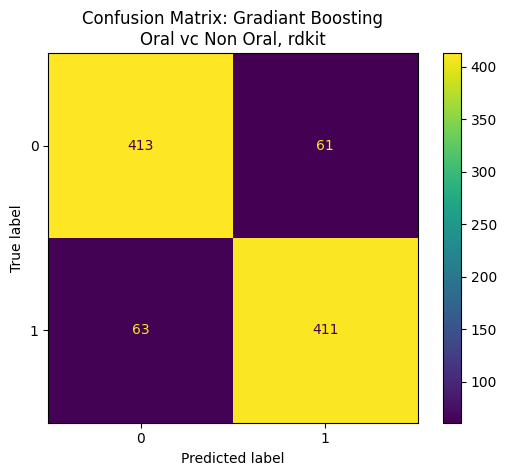

In [63]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

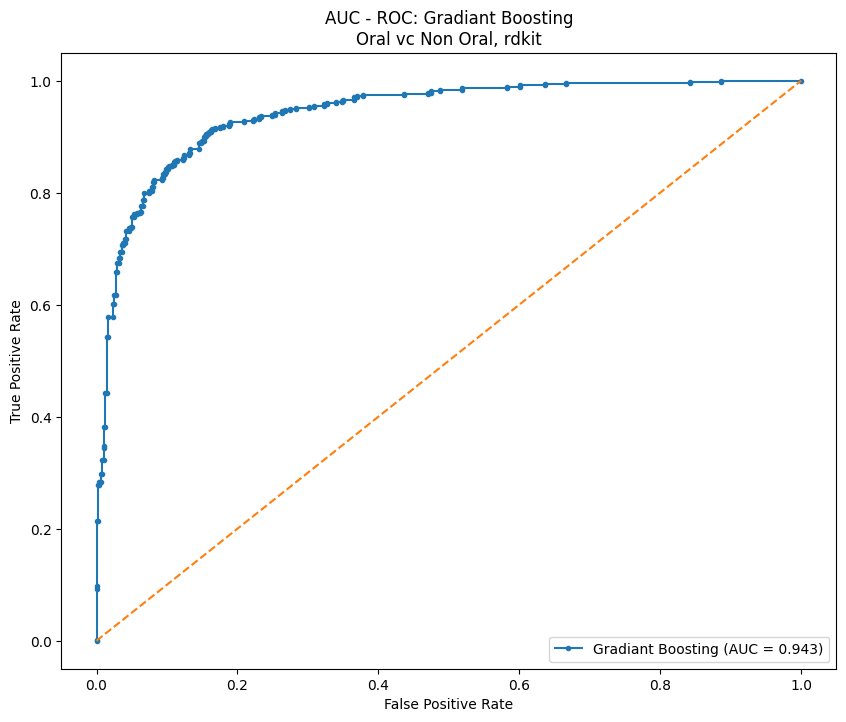

In [64]:
auc_boo = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_boo_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

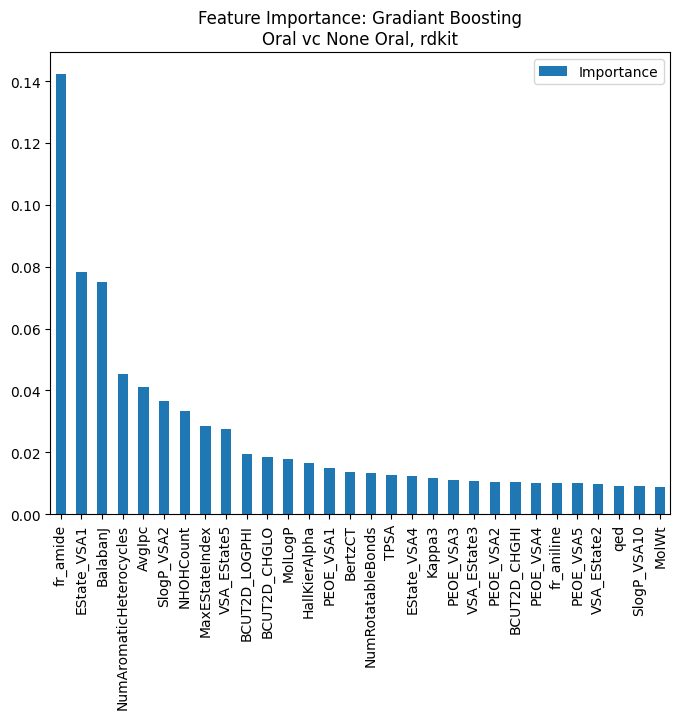

In [65]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(boosting.feature_importances_, index=x_train_scaled.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [66]:
important_features_boo = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_boo

,Importance
fr_azo,2.451242e-15
fr_dihydropyridine,3.923305e-15
fr_quatN,1.222567e-14
fr_oxazole,2.379520e-12
fr_amidine,2.202313e-11
...,...
AvgIpc,4.104805e-02
NumAromaticHeterocycles,4.545562e-02
BalabanJ,7.492168e-02
EState_VSA1,7.837954e-02


## Saving Results

In [67]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_boo["best_score"][0],
    mis_rate_boo_train,
    mis_rate_boo,
    auc_boo_train,
    auc_boo
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.906918,0.138635,0.168776,0.861365,0.915118
1,Decision Tree,0.847638,0.167136,0.217300,0.832864,0.838899
2,Random Forest,0.944589,0.000000,0.129747,1.000000,0.941068
3,Gradiant Boosting,0.951969,0.000000,0.130802,1.000000,0.942544


In [68]:
important_features_boo.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# BART

## Model Constant Variables

In [69]:
model_name_title = "BART"
model_name_path = "bart"

## Hyperparameter Fine Tuning

In [70]:
# transforming x train and test as arrays for BART procedure

x_train_bart = np.asarray(x_train)
x_test_bart = np.asarray(x_test)

In [71]:
model_params = {
    'BART': {
        'model': BART(),
        'params': {
            'num_trees': [100, 500, 1000],
            'max_stages': [100, 500, 800, 1000], # B, number of iterations
            'burnin': [5, 10, 20]
        }
    }
}

For BART, the auc present in the best_params_grid need to recieve the y_predicted in labels, but this BART algorithm does it in probabilities. Because of this, I need to use a custom scorer, that first transforms the prediction to labels.

In [72]:
score = make_scorer(bart_auc_scorer, greater_is_better=True)

gs_result_bart, gs_result_bart_full = best_params_grid(x_train_bart, y_train, model_params, scoring=score)

Starting Grid Search for BART: 13:54
Finished Grid Search for BART: 19:26
Tempo de execução:  332.5 minutos


In [73]:
gs_result_bart

,model,best_score,best_params
0,BART,0.857137,"{'burnin': 20, 'max_stages': 1000, 'num_trees'..."


# Fitting Model

In [74]:
bart_params = gs_result_bart.iloc[0,2]
bart_params

{'burnin': 20, 'max_stages': 1000, 'num_trees': 1000}

In [75]:
bart = BART(**bart_params)
bart.fit(x_train_bart, y_train)

BART(burnin=20, max_stages=1000, num_trees=1000)

## Get Training Error and AUC

In [76]:
mis_rate_bart_train, auc_bart_train = get_error_and_auc(
    model=bart, 
    x=x_train_bart,
    y_true=y_train,
    transform_prob_into_label=True
)

Training Misclassification Rate: 0.1144
Training AUC: 0.8856


## Make Prediction

In [77]:
# the bart algorithm predicts as probabilities
y_predict_bart_prob = bart.predict(x_test_bart)

In [78]:
# here I use the make_label function to transform the probabilities into labels, using 0.5 as a cutoff

make_label_v = np.vectorize(make_label)
y_predict_bart_label = make_label_v(y_predict_bart_prob)

## Test Error

In [79]:
mis_rate_bart, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_bart_label,
)

Misclassification rate: 0.1445


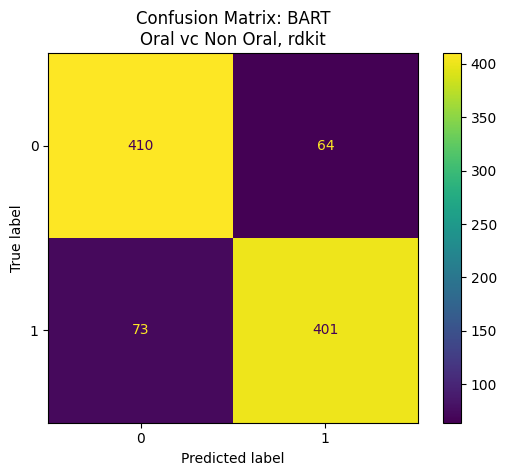

In [80]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

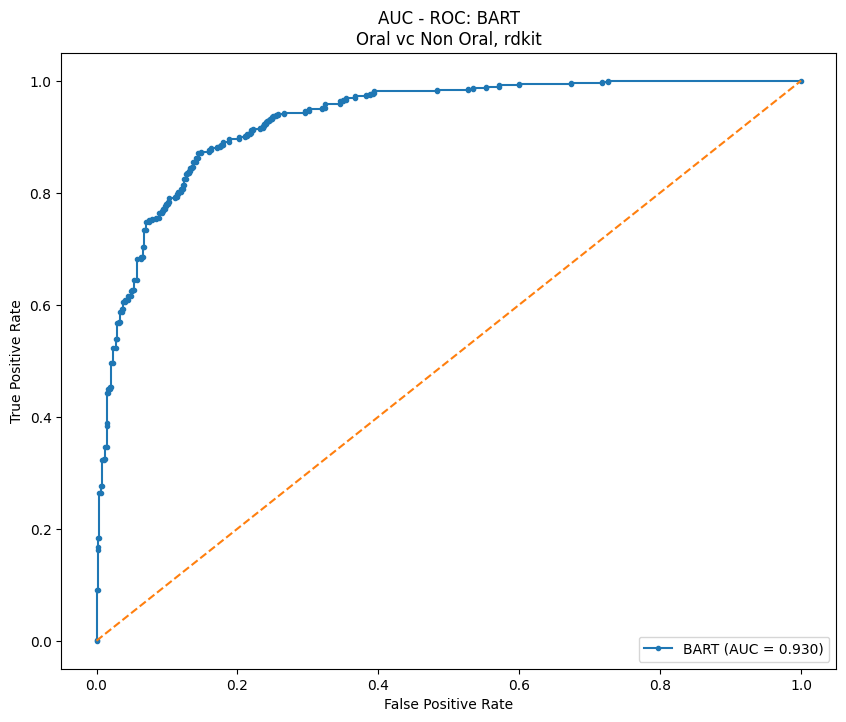

In [81]:
auc_bart = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_bart_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

We can check how many times each variable appeared in the collection
of trees. This gives a summary similar to the variable importance plot for
boosting and random forests.

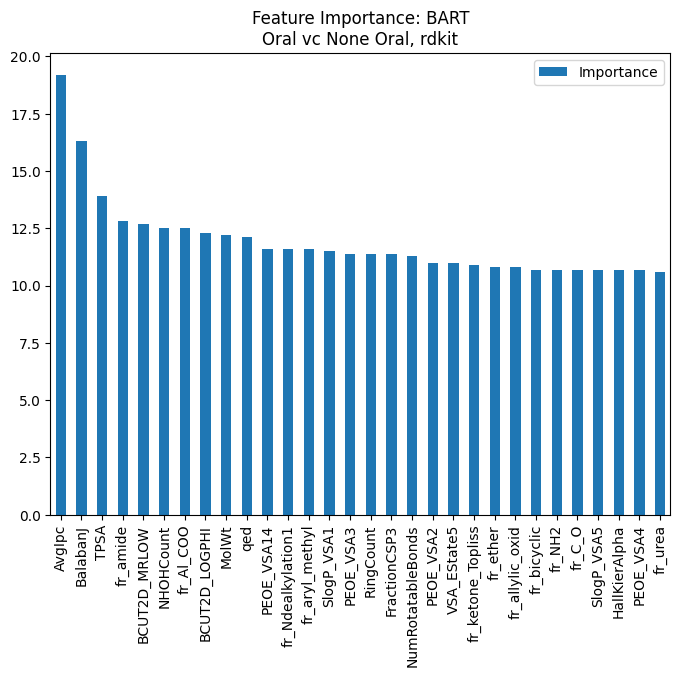

In [82]:
# Print the feature importances
fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(columns=["Importance"])
feat_importances["Importance"] = pd.Series(bart.variable_inclusion_.mean(0),index=X.columns).sort_values(ascending=False)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)


In [83]:
important_features_bart = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_bart

,Importance
MinEStateIndex,6.8
VSA_EState8,6.8
fr_priamide,7.2
fr_hdrzine,7.3
fr_Ar_COO,7.4
...,...
BCUT2D_MRLOW,12.7
fr_amide,12.8
TPSA,13.9
BalabanJ,16.3


## Saving Results

In [84]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_bart["best_score"][0],
    mis_rate_bart_train,
    mis_rate_bart,
    auc_bart_train,
    auc_bart
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.906918,0.138635,0.168776,0.861365,0.915118
1,Decision Tree,0.847638,0.167136,0.217300,0.832864,0.838899
2,Random Forest,0.944589,0.000000,0.129747,1.000000,0.941068
3,Gradiant Boosting,0.951969,0.000000,0.130802,1.000000,0.942544
4,BART,0.857137,0.114356,0.144515,0.885644,0.930295


In [85]:
important_features_bart.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# SVM

## Model Constant Variables

In [86]:
model_name_title = "SVM"
model_name_path = "svm"

## Hyperparameter Fine Tuning

In [87]:
scale = 1 / (x_train.shape[1] * x_train.var().mean())

model_params = {
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 0.3, 0.5, 0.8, 1.0, 2, 5, 10],
            'kernel': ['rbf', 'sigmoid'],
            'gamma': ['auto', scale, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10]
        }
    }
}

In [88]:
gs_result_svm, gs_result_svm_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for SVM: 19:27
Finished Grid Search for SVM: 20:12
Tempo de execução:  44.5 minutos


## Fitting Model

In [89]:
svm_params = gs_result_svm.iloc[0,2]
svm_params

{'C': 2, 'gamma': 0.0001, 'kernel': 'rbf'}

In [90]:
svm = SVC(**svm_params, probability=True).fit(x_train, y_train)

## Get Training Error and AUC

In [91]:
mis_rate_svm_train, auc_svm_train = get_error_and_auc(
    model=svm, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.0538
Training AUC: 0.9462


## Make Prediction

In [92]:
y_predict_svm_label = svm.predict(x_test)
y_predict_svm_prob = svm.predict_proba(x_test)[:, 1]

## Test Error

In [93]:
mis_rate_svm, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_svm_label,
)

Misclassification rate: 0.1582


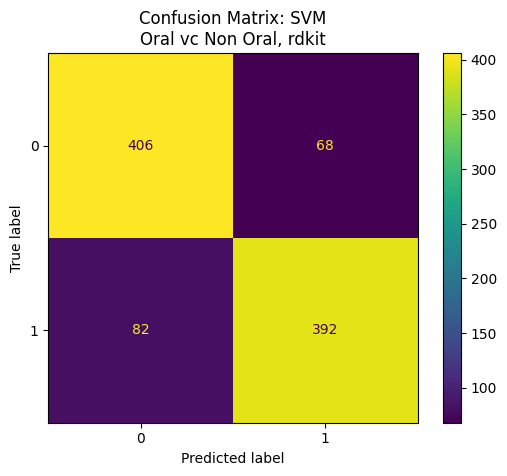

In [94]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

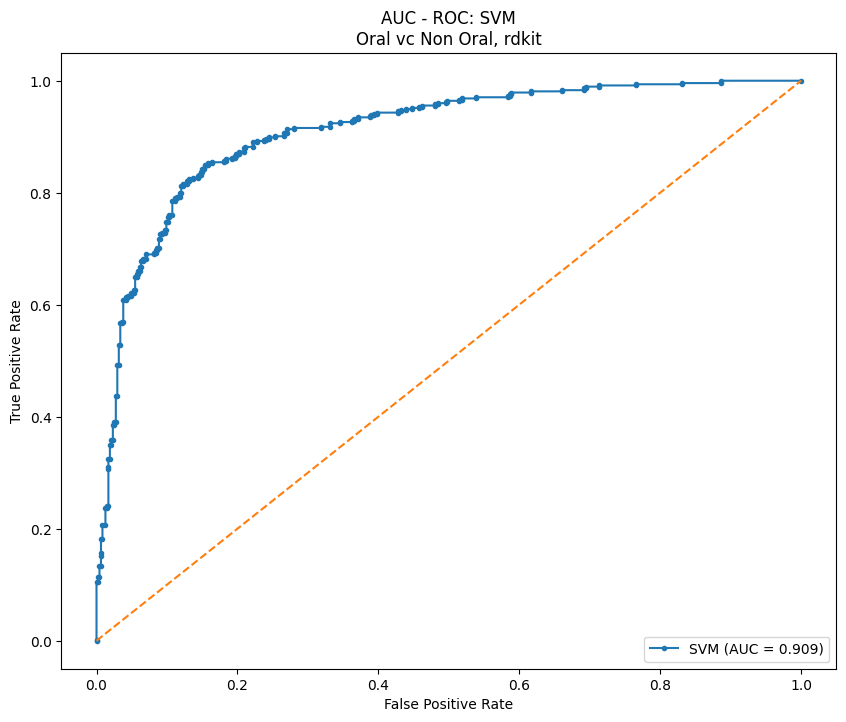

In [95]:
auc_svm = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_svm_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Saving Results

In [96]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_svm["best_score"][0],
    mis_rate_svm_train,
    mis_rate_svm,
    auc_svm_train,
    auc_svm
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.906918,0.138635,0.168776,0.861365,0.915118
1,Decision Tree,0.847638,0.167136,0.217300,0.832864,0.838899
2,Random Forest,0.944589,0.000000,0.129747,1.000000,0.941068
3,Gradiant Boosting,0.951969,0.000000,0.130802,1.000000,0.942544
4,BART,0.857137,0.114356,0.144515,0.885644,0.930295
5,SVM,0.892172,0.053835,0.158228,0.946165,0.908573


# Saving Final Datasets

In [97]:
# saving final_results dataset
final_results.to_csv(f"final_results/models_results_{DESCRIPTOR_TYPE}.csv", index=False)

In [98]:
session_info.show()